## Try to maximize the likelihood (CMB parameterization)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our modules
import likelihood
import data_MPGADGET
import gp_emulator
import p1d_arxiv

Setup mock data, from one of simulations in the suite

In [2]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
# specify simulation to use to generate synthetic data
test_sim_num=15
data=data_MPGADGET.P1D_MPGADGET(sim_number=test_sim_num,
                                basedir=basedir,
                                skewers_label=skewers_label,
                                data_cov_factor=1)

Setup archive of P1D measurements from simulations to train the emulator

In [3]:
# specify redshift range
z_max=4
# do not use test_sim_num that was used in generating mock data
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=test_sim_num,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [4]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc)
emu.load_default()

 /Users/font/Programs/Others/anaconda3/lib/python3.6/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Setup likelihood and free parameters

In [5]:
# Likelihood parameters (option to add also redshift evolution, might be slower)
add_z_evol=False
if add_z_evol:
    like_params=["As","ns","ln_tau_0","ln_tau_1",
            "ln_sigT_kms_0","ln_sigT_kms_1","ln_gamma_0","ln_gamma_1",
            "ln_kF_0","ln_kF_1"]
    like_param_limits=[[2.e-9,2.3e-9 ], [0.94, 0.98], [-0.2, 0.2], [-0.2, 0.2],
            [-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2],
            [-0.2, 0.2], [-0.2, 0.2]]
else:
    like_params=["As","ns","ln_tau_0","ln_sigT_kms_0",
            "ln_gamma_0","ln_kF_0"]
    like_param_limits=[[2.e-9,2.3e-9 ], [0.94, 0.98], [-0.2, 0.2],
            [-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2]]

In [6]:
like=likelihood.Likelihood(data=data,emulator=emu,
                            free_parameters=like_params,
                            free_param_limits=like_param_limits,
                            verbose=False,
                            prior_Gauss_rms=-1,
                            emu_cov_factor=1,
                            use_sim_cosmo=False)

In [7]:
## Evaluate log_prob at random point in parameter space
theta=np.ones(len(like_params))*0.5 ## Just pick the middle of likelihood space
print('starting point')
for par in like.parameters_from_sampling_point(theta):
    print(par.info_str())
chi2_test=like.get_chi2(theta)
print('starting chi2',chi2_test)

starting point
As = 2.1500000000000002e-09
ns = 0.96
ln_tau_0 = 0.0
ln_sigT_kms_0 = 0.0
ln_gamma_0 = 0.0
ln_kF_0 = 0.0
starting chi2 661.0502925647246


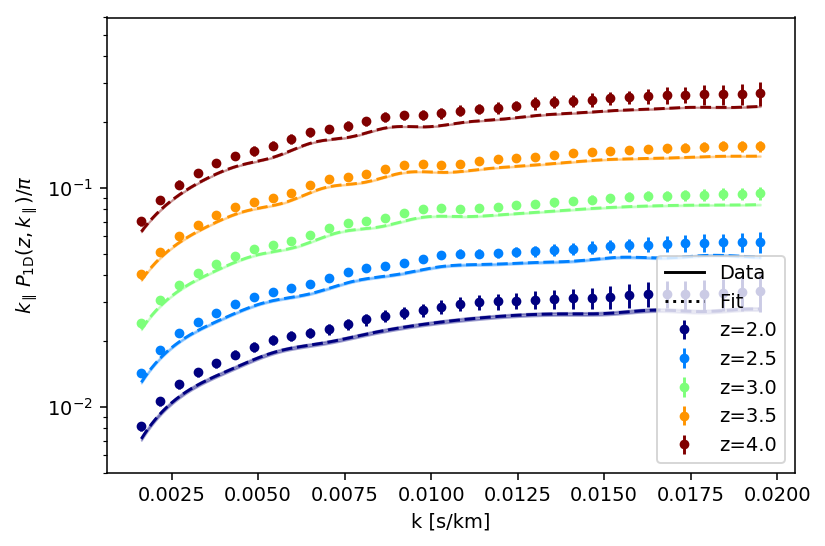

In [8]:
like.plot_p1d(plot_every_iz=2)

# Run minimiser

In [9]:
from scipy.optimize import minimize
results=minimize(like.get_chi2, x0=theta)
print('minimum chi2 =',results.fun)
max_like=like.log_prob(results.x)
print('maximum likelihood',max_like)
for par in like.parameters_from_sampling_point(results.x):
    print(par.info_str())

minimum chi2 = 7.857505623073395
maximum likelihood -inf
As = 2.1074541496895855e-09
ns = 0.9941141195077469
ln_tau_0 = 0.026371370364276503
ln_sigT_kms_0 = 0.2092852738413324
ln_gamma_0 = -0.14966668807936354
ln_kF_0 = 0.12067495282808116


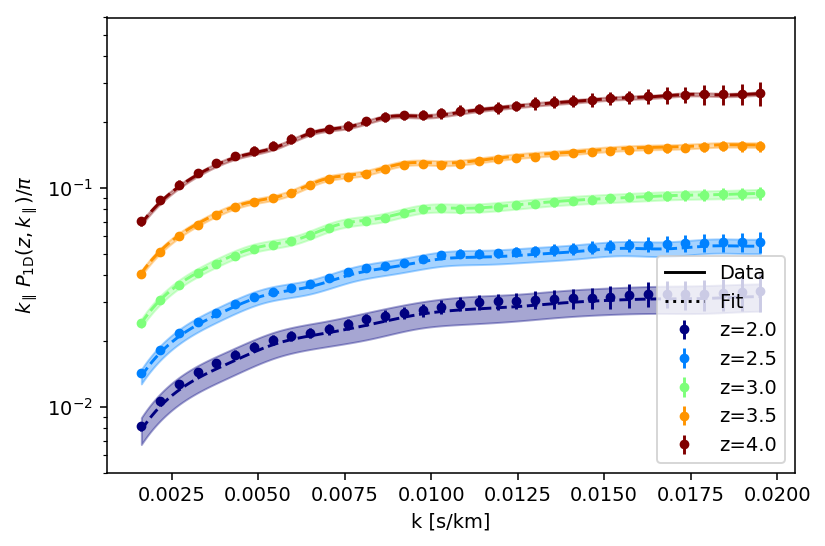

In [10]:
like.plot_p1d(plot_every_iz=2,values=results.x)

The plot looks good, but the maximum likelihood is - infinity...